## 1 Prepare data

In [11]:
from scipy import stats
import numpy as np
import pandas as pd
import wrangle as wr
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

#talos items
import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from talos.model.normalizers import lr_normalizer


# Keras items
from keras import backend as K
from keras.optimizers import Nadam,SGD,RMSprop,Adagrad,Adadelta,Adam,Adamax,Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.models import model_from_json


In [98]:
attrs=[]
attr_types={}
with open('communities.attrs','r') as g:
    attr=g.readline()
    while attr:
        redundant,attr,cat=attr.split()
        if cat not in attr_types:
                attr_types[cat]=set()
        attr_types[cat].add(attr)
        attrs.append(attr)
        attr=g.readline()

A=[]
index=[]
def convert(i):
    try:
        return float(i)
    except:
        return -1.
    
with open("communities.data", "r") as f:
    data=f.readline()
    while data:
        x=data.split(',')
        x[-1]=x[-1][:-1]
        index.append(x[3])
        data=f.readline()
        A.append([convert(i) for i in x])
    
data=pd.DataFrame.from_records(A, index=index, columns=attrs)
display(data.head())
print(data.shape)
#data is dataframe indexed by 'communityname' each enry has 128 numeric entry 
#with ''ViolentCrimesPerPop' be the target of regrssion

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
Lakewoodcity,8.0,-1.0,-1.0,-1.0,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
Tukwilacity,53.0,-1.0,-1.0,-1.0,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.67
Aberdeentown,24.0,-1.0,-1.0,-1.0,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.43
Willingborotownship,34.0,5.0,81440.0,-1.0,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.12
Bethlehemtownship,42.0,95.0,6096.0,-1.0,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.03


(1994, 128)


In [99]:
target='ViolentCrimesPerPop'
x=data.drop(target, 1).values
#normaalize x to have std 1 and mean 0
x = wr.mean_zero(pd.DataFrame(x)).fillna(1).values# commeny this line before exp 7
y=data[target].values
total=len(data[target])
split=int(total*0.2)
x_test=x[:split]
y_test=y[:split]
x=x[split:]
y=y[split:]
rest_total=len(x)
split=int(rest_total*0.2)
x_val=x[:split]
y_val=y[:split]
x_train=x[split:]
y_train=y[split:]
#split .2 of total data for testing split .2 of rest data for validating rest is for training
len(x_train),len(x_val),len(x_test)

(1277, 319, 398)

In [100]:
print(x_train[0])
print(y)

[ 0.01929857 -0.28533314 -0.67836511  1.         -0.51988205 -0.05983002
  0.83439739 -0.51147346  0.76333517 -0.44849761 -0.49043516  0.55273651
  0.11237814 -0.27785301 -1.52447882 -0.03175065  0.68283272  0.52003883
  1.43153181 -0.6936034   0.1926929  -1.61925846 -0.80031033 -1.36812261
  0.27400313 -0.10596468 -0.3107487   0.51809507  0.22148019  0.34615744
  0.70373755 -0.03429548 -0.27752294 -0.8448399  -1.1052114  -1.15220152
  0.08759836 -0.85833451  1.48777387 -0.3280077  -0.4023596  -0.35804805
 -0.00718774 -0.44526787 -1.05139184 -0.10028958 -0.24112867  0.72610623
  0.88665019  0.96602701  0.85014158  0.71598619  0.99963873  1.10310629
 -0.33397942 -0.8697472  -0.34476848 -0.54868536 -0.76151457 -0.73984461
 -0.50201956 -0.68435073 -0.68600826 -0.69601694 -0.65103956  0.67923459
 -0.50331657 -0.39481565 -0.16722197  1.16719024  1.36503456  0.29531135
  0.79864288 -0.60138081 -1.42129874  0.72617276 -0.24467856  0.46618615
  0.65502865  0.66800404 -0.70552989  1.35857045 -0

## 2. Creating the Keras Model

In [44]:
# first we have to make sure to input data and params into the function
# def breast_cancer_model(x_train, y_train, x_val, y_val, params):

#     model = Sequential()
#     model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
#                     activation=params['first_activation'],
#                     kernel_initializer=params['kernel_initializer']))
    
#     model.add(Dense(params['second_neuron'], activation=params['activation']))
#     model.add(Dropout(params['dropout']))

#     model.add(Dense(1, activation=params['last_activation']
#                     ))
    
#     model.compile(loss=params['losses'],
#                   optimizer=params['optimizer'](),
#                   metrics=['acc', fmeasure_acc])
    
#     history = model.fit(x_train, y_train, 
#                         validation_data=[x_val, y_val],
#                         batch_size=params['batch_size'],
#                         callbacks=[live()],
#                         epochs=params['epochs'],
#                         verbose=0)

#     return history, model

def crime_model(x_train, y_train, x_val, y_val, p):
    
    #print("Val size",np.shape(x_val))
    model = Sequential()
    model.add(Dense(p['first_neuron'], input_dim=x_train.shape[1],
                    activation=p['first_activation'],
                    kernel_initializer=p['kernel_initializer']))
    for i in range(p['hidden_layer']):
        model.add(Dense(p['hidden_neuron'], activation=p['activation']))
        Dropout(rate=p['drop_out'])
    #model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation=p['last_activation']
                    ))
    def r_value( y_true,y_pred):###actually returns 1-r
        return 1-K.mean(normalize(y_true)*normalize(y_pred))
    def normalize(x):
        return K.batch_normalization(x,K.mean(x),K.var(x),beta=0,gamma=1)
    model.compile(loss=p['losses'],
                  optimizer=p['optimizers'](lr_normalizer(p['lr'], p['optimizers'])),
                  metrics=[r_value])
    
    history = model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val),
                        callbacks=[live()],
                        epochs=p['epochs'],
                        verbose=0)
   # print("Val size",np.shape(x_val),np.shape(y_val))

    return history, model



In [45]:
# run this code just once
best_param_each_round={}
data_each_round={}
exp_nums=set()

## 3. Defining the Parameter Space Boundary

In [126]:
# set the parameter space
para_spaces={}
#test para space for the first round:
p={
    'first_neuron':[10],
    'first_activation':['relu'],
    'hidden_layer':[3],
     'hidden_neuron':[8],
     'batch_size': [30],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': [Adam],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[1]=p 

#test para space for the second round:
p={
    'first_neuron':[12,18,24],
    'first_activation':['relu','linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': [Adam],
     'losses': ['MSE'],
     'activation':['relu','linear'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[2]=p

#test para space for the third round:
p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': [SGD,RMSprop,Adagrad,Adadelta,Adam,Adamax,Nadam],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[3]=p
#test para space for the fourth round:
p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[2,3,4],
     'hidden_neuron':[2,4,8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': [Adam],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[4]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8,16,24],
     'batch_size': [60],
     'epochs': [120],
     'kernel_initializer': ['normal'],
     'optimizers': [Adam],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[5]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': [Adam],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[6]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': [SGD],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1,5,10,50,100],
    'drop_out':[0]
  }
para_spaces[7]=p

p={
    'first_neuron':[24],
    'first_activation':['linear','relu'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': [SGD],
     'losses': ['MSE'],
     'activation':['linear','relu'],
     'last_activation': ['linear'],
    'lr':[5],
    'drop_out':[0]
  }
para_spaces[8]=p

p={
    'first_neuron':[24],
    'first_activation':['relu'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': [SGD,RMSprop,Adagrad,Adadelta,Adam,Adamax,Nadam],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0]
  }
para_spaces[9]=p

p={
    'first_neuron':[12,24],
    'first_activation':['relu'],
    'hidden_layer':[2],
     'hidden_neuron':[8,16],
     'batch_size': [20],
     'epochs': [80],
     'kernel_initializer': ['normal'],
     'optimizers': [RMSprop],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0,0.1]
  }
para_spaces[10]=p

p={
    'first_neuron':[12,18,24],
    'first_activation':['relu'],
    'hidden_layer':[0,1,2],
     'hidden_neuron':[8,16,24],
     'batch_size': [20,40],
     'epochs': [80],
     'kernel_initializer': ['normal'],
     'optimizers': [RMSprop],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0.1]
  }
para_spaces[11]=p

## 4. Starting the Experiment

In [136]:
exp_round=11
exp_nums.add(exp_round)

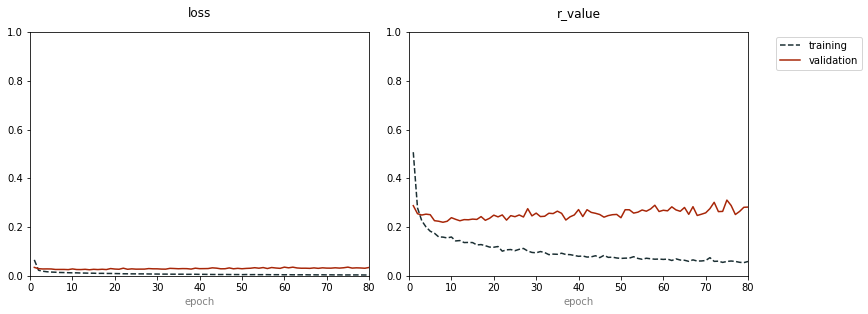







100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [43:27<00:00, 58.61s/it]

Scan Finished!


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
0,80,0.0258862454339,0.209168862586,0.00395843339975,0.0613479524641,12,relu,1,24,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
1,80,0.0239218882516,0.21093914875,0.00294093445845,0.051931288528,24,relu,2,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
2,80,0.0282147693153,0.236351296819,0.00222598045234,0.0414462834013,24,relu,1,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
3,80,0.0256864343621,0.225688712163,0.00218709277211,0.0444136977476,18,relu,2,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
4,80,0.0233081132232,0.20376377812,0.00310837021411,0.0521051638651,18,relu,2,8,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
5,80,0.0280035036648,0.240896329984,0.00419575599049,0.0642949865494,12,relu,1,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
6,80,0.027745573434,0.226295414016,0.00616849257524,0.0831840109246,18,relu,0,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
7,80,0.0301909559584,0.233118683754,0.00770850007815,0.0951337265427,12,relu,0,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
8,80,0.0266977427089,0.231344304675,0.00279584254365,0.0486640583377,18,relu,1,16,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
9,80,0.0267717974395,0.231461766372,0.00191847735176,0.0381273337426,24,relu,1,24,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1


In [137]:
t = ta.Scan(x=x_train,
            y=y_train,
            model=crime_model,
            params=para_spaces[exp_round],x_val=x_val,y_val=y_val,print_params=False)
t.data

## 5. Predict on valiation data

In [138]:
def best_model(self, metric, asc):

    '''Picks the best model based on a given metric and
    returns the index number for the model.

    NOTE: for loss 'asc' should be True'''

    best = self.data.sort_values(metric, ascending=asc).iloc[0].name

    return best


def activate_model(self, model_id):

    '''Loads the model from the json that is stored in the Scan object'''

    model = model_from_json(self.saved_models[model_id])
    model.set_weights(self.saved_weights[model_id])

    return model
def graph(x, y, x_label="x_label", y_label="y_label", col="blue", savename="default"):
    # Get correlation
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    rsquared = r_value ** 2
    print("r-squared:", rsquared)
    
    # Graph
    fig = plt.figure(figsize=(6, 6))
    fig.suptitle("r-squared = " + str(rsquared), fontsize = 30)
    plt.scatter(x, y, alpha = 0.2, color = col)
    plt.xlabel(x_label, fontsize = 20)
    plt.ylabel(y_label, fontsize = 20)
    plt.savefig(savename + ".png")
    plt.show()
    
def evaluate(model,train_x,train_y,valid_x,valid_y,test_x,test_y):
    graph(test_y, model.predict(test_x).ravel(),'true_test','pred_test')
    graph(valid_y, model.predict(valid_x).ravel(),'true_val','pred_val')
    graph(train_y, model.predict(train_x).ravel(),'true_train','pred_train')


In [139]:
#save result of experiment

#choose the best model by sorting the lowest 1-r_value for the validation and save it
data=ta.Predict(t).scan_object.data.sort_values("val_r_value")
ta.Deploy(t, 'best_crime_model'+str(exp_round),metric='val_r_value',asc=True)

#save all performance of all models in para_space 
data_each_round[exp_round]=data

#sace best parameters for this experiment
r=ta.Reporting(t)
best_param_each_round[exp_round]=r.best_params('val_r_value',ascending=True)[0]


Deploy package best_crime_model11 have been saved.


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
4,80,0.0233081132232,0.20376377812,0.00310837021411,0.0521051638651,18,relu,2,8,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
43,80,0.0247193238987,0.204578684789,0.00175323494938,0.0373760232164,24,relu,2,24,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
12,80,0.0249407249547,0.207707941719,0.00248090597271,0.0470627091691,18,relu,1,24,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
0,80,0.0258862454339,0.209168862586,0.00395843339975,0.0613479524641,12,relu,1,24,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
1,80,0.0239218882516,0.21093914875,0.00294093445845,0.051931288528,24,relu,2,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
26,80,0.0243309934428,0.215769047274,0.00264247507231,0.046047326262,18,relu,2,16,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
42,80,0.0254249614153,0.216498476958,0.00332652069242,0.0539742059883,18,relu,1,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
17,80,0.0246408213993,0.216644957335,0.00365957819704,0.0587725001289,12,relu,2,16,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
44,80,0.0258894976182,0.216790490016,0.00353028831971,0.0565000125553,12,relu,2,24,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
14,80,0.0255532522093,0.217514098812,0.00289675885007,0.0514231111355,24,relu,1,8,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1


['1' "<class 'keras.optimizers.RMSprop'>" 'relu' 'MSE' 'linear' '40' '18'
 '80' '0.1' '8' '0.0521051638651' '2' 'normal' 'relu' 0]
r-squared: 0.502721306763


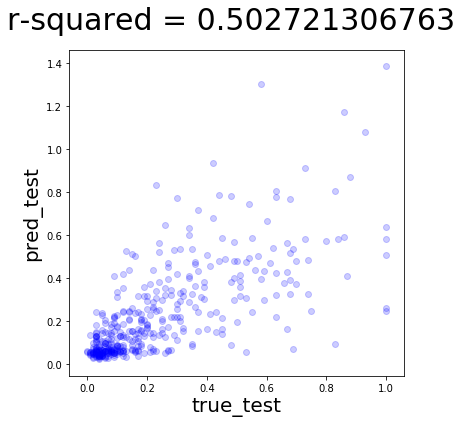

r-squared: 0.569117141761


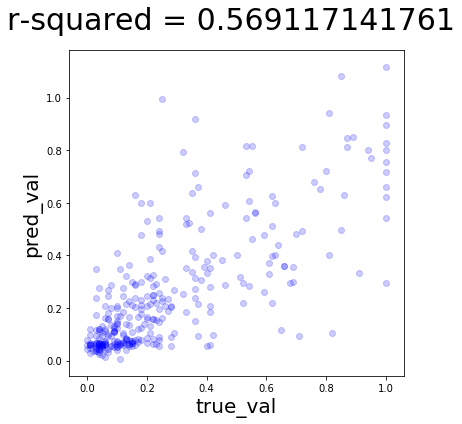

r-squared: 0.934805657083


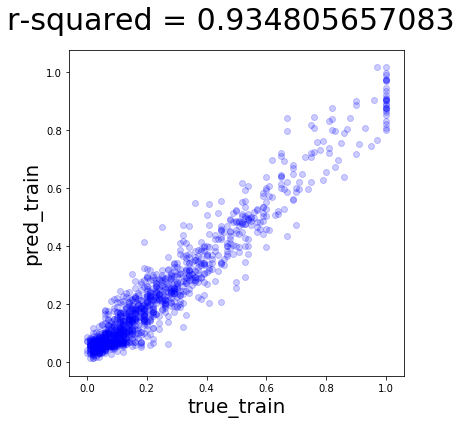

In [140]:
display(data)
print(r.best_params('val_r_value',ascending=True)[0])
#visualize the predict and truth and compute the r_squared
evaluate(activate_model(ta.Predict(t).scan_object, data.index[0]),x_train,y_train,x_val,y_val,x_test,y_test)

## 6. Data analysis

In [141]:
def summary(para_spaces,best_param_each_round,data_each_round,exp_round):
    for i in exp_nums:
        print('experiment ',i)
        print('para_spaces is ')
        print(para_spaces[i])
        print('best parameter in para sapces')
        print(best_param_each_round[i])
        print('data overview')
        display(data_each_round[i].head())

In [142]:
summary(para_spaces,best_param_each_round,data_each_round,exp_round)

experiment  1
para_spaces is 
{'first_neuron': [10], 'first_activation': ['relu'], 'hidden_layer': [3], 'hidden_neuron': [8], 'batch_size': [30], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.Adam'>], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'relu' 'MSE' 'linear' '30' '10' '40'
 '0' '8' '0.299309621916' '3' 'normal' 'relu' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
0,40,0.0432487126311,0.385232732401,0.0244803021581,0.299309621916,10,relu,3,8,30,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0


experiment  2
para_spaces is 
{'first_neuron': [12, 18, 24], 'first_activation': ['relu', 'linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.Adam'>], 'losses': ['MSE'], 'activation': ['relu', 'linear'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'relu' 'MSE' 'linear' '20' '18' '40'
 '0' '8' '0.274700836456' '2' 'normal' 'relu' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
3,40,0.0360977178188,0.306953981005,0.0225332438356,0.274700836456,18,relu,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0
19,40,0.037477283613,0.327893584873,0.0301713284937,0.343444933486,24,linear,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0
17,40,0.0389999485689,0.339375789076,0.0242332072204,0.291156340691,12,relu,1,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0
13,40,0.0471165784661,0.364556009119,0.0415752711899,0.450669349407,18,linear,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
23,40,0.0447698062619,0.402519892376,0.0266650060488,0.321679832045,18,linear,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0


experiment  3
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adadelta'>, <class 'keras.optimizers.Adam'>, <class 'keras.optimizers.Adamax'>, <class 'keras.optimizers.Nadam'>], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'linear' 'MSE' 'linear' '20' '24'
 '40' '0' '8' '0.582507510015' '1' 'normal' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
9,40,0.0766091347792,0.539060117309,0.0680531718204,0.582507510015,24,linear,1,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
6,40,0.829488968774,0.564099738964,0.524791993288,0.635720425177,24,linear,1,8,20,40,normal,<class 'keras.optimizers.Nadam'>,MSE,linear,linear,1,0
11,40,0.205910971312,0.712327609615,0.169416562166,0.806518325231,24,linear,2,8,20,40,normal,<class 'keras.optimizers.Adadelta'>,MSE,linear,linear,1,0
10,40,0.0645010311705,0.772067669417,0.048951056826,0.808981165162,24,linear,2,8,20,40,normal,<class 'keras.optimizers.RMSprop'>,MSE,linear,linear,1,0
1,40,0.198885241132,0.775881536515,0.178096573639,0.832948222651,24,linear,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0


experiment  4
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [2, 3, 4], 'hidden_neuron': [2, 4, 8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.Adam'>], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'linear' 'MSE' 'linear' '20' '24'
 '40' '0' '4' '0.24883751479' '3' 'normal' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
6,40,0.0302821932985,0.25909016237,0.0209125456143,0.24883751479,24,linear,3,4,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
1,40,0.0395778837004,0.323983382095,0.0266054627488,0.319670945849,24,linear,3,2,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
2,40,0.0385557204882,0.338809725072,0.0305135540122,0.390394936153,24,linear,4,4,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
8,40,0.0693692250475,0.456484998842,0.0433614815854,0.5343525574,24,linear,4,2,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
0,40,0.122417876666,0.499098936405,0.118547803393,0.639855306598,24,linear,3,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0


experiment  5
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8, 16, 24], 'batch_size': [60], 'epochs': [120], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.Adam'>], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'linear' 'MSE' 'linear' '60' '24'
 '120' '0' '8' '0.332103123726' '1' 'normal' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
5,120,0.0452545309749,0.289712561148,0.0336477893755,0.332103123726,24,linear,1,8,60,120,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
2,120,0.059296636197,0.293868115143,0.0324542911646,0.376843802427,24,linear,2,8,60,120,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
1,120,0.0354604715318,0.299277410425,0.0270359698266,0.323490686359,24,linear,2,24,60,120,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
4,120,0.0406333007222,0.323730942971,0.0320993973235,0.414235619287,24,linear,1,16,60,120,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0
3,120,0.0630485997725,0.325779480994,0.0489152954686,0.458900534976,24,linear,2,16,60,120,normal,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0


experiment  6
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': [<class 'keras.optimizers.Adam'>], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'linear' 'MSE' 'linear' '120' '24'
 '120' '0' '24' '0.320542505456' '1' 'uniform' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
0,120,0.0515508492095,0.261264136592,0.03746387811,0.320542505456,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.Adam'>,MSE,linear,linear,1,0


experiment  7
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': [<class 'keras.optimizers.SGD'>], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1, 5, 10, 50, 100], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.SGD'>" 'linear' 'MSE' 'linear' '120' '24'
 '120' '0' '24' '0.169546985776' '1' 'uniform' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
4,120,0.0253150566104,0.218986219934,0.0143876143147,0.169546985776,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,1,0
1,120,0.0249740148086,0.219868853361,0.0142503643063,0.16326931168,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,5,0
0,120,nan,nan,nan,nan,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,100,0
2,120,nan,nan,nan,nan,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,10,0
3,120,nan,nan,nan,nan,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,50,0


experiment  8
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear', 'relu'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': [<class 'keras.optimizers.SGD'>], 'losses': ['MSE'], 'activation': ['linear', 'relu'], 'last_activation': ['linear'], 'lr': [5], 'drop_out': [0]}
best parameter in para sapces
['5' "<class 'keras.optimizers.SGD'>" 'linear' 'MSE' 'linear' '120' '24'
 '120' '0' '24' '0.166130022743' '1' 'uniform' 'linear' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
3,120,0.0247970395503,0.218449337355,0.0142333630958,0.166130022743,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,5,0
0,120,0.0256595726134,0.22483739752,0.00336512061275,0.0567383534197,24,relu,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,relu,linear,5,0
2,120,0.0279501111518,0.237794608532,0.00407594958643,0.0613357663248,24,relu,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,linear,linear,5,0
1,120,0.0277918791661,0.240397713588,0.00459647121363,0.0712218978672,24,linear,1,24,120,120,uniform,<class 'keras.optimizers.SGD'>,MSE,relu,linear,5,0


experiment  9
para_spaces is 
{'first_neuron': [24], 'first_activation': ['relu'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adadelta'>, <class 'keras.optimizers.Adam'>, <class 'keras.optimizers.Adamax'>, <class 'keras.optimizers.Nadam'>], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0]}
best parameter in para sapces
['1' "<class 'keras.optimizers.Adam'>" 'relu' 'MSE' 'linear' '20' '24' '40'
 '0' '8' '0.0821685896036' '2' 'normal' 'relu' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
6,40,0.0254949422839,0.220632785353,0.00562623785641,0.0821685896036,24,relu,2,8,20,40,normal,<class 'keras.optimizers.Adam'>,MSE,relu,linear,1,0
13,40,0.0260841429502,0.222622196689,0.00536623790447,0.0778871194497,24,relu,2,8,20,40,normal,<class 'keras.optimizers.Adadelta'>,MSE,relu,linear,1,0
11,40,0.0260165688293,0.227079825528,0.00370215641618,0.05919980256,24,relu,2,8,20,40,normal,<class 'keras.optimizers.Nadam'>,MSE,relu,linear,1,0
5,40,0.0277131962879,0.23125980715,0.00469196452588,0.0721233108591,24,relu,1,8,20,40,normal,<class 'keras.optimizers.Nadam'>,MSE,relu,linear,1,0
4,40,0.0269046587735,0.234181011732,0.00656404567316,0.0891794092317,24,relu,2,8,20,40,normal,<class 'keras.optimizers.Adagrad'>,MSE,relu,linear,1,0


experiment  10
para_spaces is 
{'first_neuron': [12, 24], 'first_activation': ['relu'], 'hidden_layer': [2], 'hidden_neuron': [8, 16], 'batch_size': [20], 'epochs': [80], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.RMSprop'>], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0, 0.1]}
best parameter in para sapces
['1' "<class 'keras.optimizers.RMSprop'>" 'relu' 'MSE' 'linear' '20' '12'
 '80' '0' '8' '0.0651837061323' '2' 'normal' 'relu' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
1,80,0.0245844599525,0.212999886667,0.0042962012426,0.0651837061323,12,relu,2,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0
3,80,0.0256703253135,0.216554419748,0.00331550188247,0.054164709341,12,relu,2,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
4,80,0.0258207600564,0.217878311219,0.00199419468479,0.0416817215148,24,relu,2,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
7,80,0.0254137415007,0.218308584443,0.00480106369335,0.069744339611,12,relu,2,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
0,80,0.0252546029557,0.221007676894,0.00326092938033,0.0562262850622,12,relu,2,16,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0


experiment  11
para_spaces is 
{'first_neuron': [12, 18, 24], 'first_activation': ['relu'], 'hidden_layer': [0, 1, 2], 'hidden_neuron': [8, 16, 24], 'batch_size': [20, 40], 'epochs': [80], 'kernel_initializer': ['normal'], 'optimizers': [<class 'keras.optimizers.RMSprop'>], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0.1]}
best parameter in para sapces
['1' "<class 'keras.optimizers.RMSprop'>" 'relu' 'MSE' 'linear' '40' '18'
 '80' '0.1' '8' '0.0521051638651' '2' 'normal' 'relu' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
4,80,0.0233081132232,0.20376377812,0.00310837021411,0.0521051638651,18,relu,2,8,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
43,80,0.0247193238987,0.204578684789,0.00175323494938,0.0373760232164,24,relu,2,24,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
12,80,0.0249407249547,0.207707941719,0.00248090597271,0.0470627091691,18,relu,1,24,40,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
0,80,0.0258862454339,0.209168862586,0.00395843339975,0.0613479524641,12,relu,1,24,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1
1,80,0.0239218882516,0.21093914875,0.00294093445845,0.051931288528,24,relu,2,8,20,80,normal,<class 'keras.optimizers.RMSprop'>,MSE,relu,linear,1,0.1


## 7 Final model

In [ ]:
re = ta.Restore('best_crime_model11.zip')
evaluate(re.model,x_train,y_train,x_val,y_val,x_test,y_test)